## **0. Tải bộ dữ liệu**
**Lưu ý:** Nếu không thể tải bằng gdown do bị giới hạn số lượt tải, các bạn hãy tải thủ công và đưa lên drive của mình, sau đó copy từ drive vào colab.
```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

In [1]:
# https://drive.google.com/file/d/1o09HEkDBBEjsW3gN76vDYfCAKiCqpcpg/view?usp=share_link
!gdown --id 1o09HEkDBBEjsW3gN76vDYfCAKiCqpcpg

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1o09HEkDBBEjsW3gN76vDYfCAKiCqpcpg
To: /content/financial_sentiment.zip
100% 925k/925k [00:00<00:00, 136MB/s]


In [2]:
!unzip './financial_sentiment.zip'

Archive:  ./financial_sentiment.zip
  inflating: FinancialPhraseBank/License.txt  
  inflating: FinancialPhraseBank/README.txt  
  inflating: FinancialPhraseBank/Sentences_50Agree.txt  
  inflating: FinancialPhraseBank/Sentences_66Agree.txt  
  inflating: FinancialPhraseBank/Sentences_75Agree.txt  
  inflating: FinancialPhraseBank/Sentences_AllAgree.txt  
  inflating: all-data.csv            


## **1. Import các thư viện cần thiết**

In [3]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 27.9 MB/s 


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import nltk
import unidecode

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split

RANDOM_SEED = 1
tf.random.set_seed(RANDOM_SEED)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## **2. Chuẩn bị dữ liệu**

In [5]:
english_stop_words = stopwords.words('english') # Lấy danh sách stopwords từ thư viện ntlk
stemmer = PorterStemmer() # Khai báo stemmer object (dùng để stemming trong hàm normalize text)

# Xây dựng hàm text normalization
def text_normalize(text):
    text = text.lower() # Chuyển chữ viết thường 
    text = unidecode.unidecode(text) # Mã hóa về ASCII
    text = text.strip() # Xóa kí tự đặc biệt ở đầu và cuối string
    text = re.sub(r'[^\w\s]', '', text) # Loại bỏ dấu câu
    text = ' '.join([word for word in text.split(' ') if word not in english_stop_words]) # Xóa stopwords
    text = ' '.join([stemmer.stem(word) for word in text.split(' ')]) # Stemming
 
    return text

In [6]:
DATASET_CSV_FILEPATH = './all-data.csv' # Khai báo đường dẫn đến file .csv của dataset
headers = ['sentiment', 'content'] # Khai báo danh sách tên các cột trong file .csv (vì dataset gốc không có)

df = pd.read_csv(DATASET_CSV_FILEPATH, names=headers, encoding='ISO-8859-1') # Đọc file .csv thành DataFrame
df['content'] = df['content'].apply(lambda p: text_normalize(p)).astype(str) # Áp dụng hàm normalize text vào cột `content`
classes_lst = df['sentiment'].unique() # Danh sách tên các class trong dataset
n_classes = len(classes_lst) # Tìm số lượng class trong bộ dữ liệu

# Chia bộ dữ liệu thành 3 bộ train, val, test
train_df, val_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=0) 
val_df, test_df = train_test_split(val_df, test_size=0.5, shuffle=True, random_state=0)

In [7]:
ROOT_FOLDERPATH = './financial_sentiment' # Khai báo đường dẫn đến folder root chứa dataset

# Khởi tạo folder root của dataset nếu chưa tồn tại trong disk
if not os.path.exists(ROOT_FOLDERPATH): 
    os.makedirs(ROOT_FOLDERPATH)

for folder_name in ['train', 'val', 'test']:
    # Khai báo đường dẫn đến folder 
    folder_path = os.path.join(ROOT_FOLDERPATH, folder_name) 

    # Tạo folder nếu chưa tồn tại trong disk
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    for class_name in classes_lst:
        # Khai báo đường dẫn đến folder của class 
        class_folder_path = os.path.join(folder_path, class_name)

        # Tạo folder nếu chưa tồn tại trong disk
        if not os.path.exists(class_folder_path):
            os.makedirs(class_folder_path)

    if folder_name == 'train':
        df = train_df
    elif folder_name == 'val':
        df = val_df
    else:
        df = test_df

    # Tạo bộ đếm số lượng sample cho từng class (dùng để đặt tên file .txt cho sample)
    counter_dict = dict.fromkeys(classes_lst, 1) 

    # Tạo các data sample dưới dạng các file .txt
    for idx, row in df.iterrows(): # Duyệt qua từng hàng trong file .csv của tập train
        sample_sentiment = row['sentiment'] # Lấy label của sample
        sample_content = row['content'] # Lấy nội dung văn bản của sample
        sample_filepath = os.path.join(ROOT_FOLDERPATH, folder_name, sample_sentiment, f'{sample_sentiment}_{counter_dict[sample_sentiment]}.txt') # Khai báo đường dẫn lưu file .txt
        counter_dict[sample_sentiment] += 1 
        # Tạo file .txt với nội dung là ô content trong file .csv của hàng đang xét
        with open(sample_filepath, 'w') as f: 
            f.write(sample_content)

In [8]:
BATCH_SIZE = 128
MAX_SEQ_LEN = 128
MAX_FEATURES = 5000 # vocab size
EMBEDDING_DIMS = 64

ROOT_FOLDERPATH = './financial_sentiment'

trainset_filepath = os.path.join(ROOT_FOLDERPATH, 'train') 
valset_filepath = os.path.join(ROOT_FOLDERPATH, 'val') 
testset_filepath = os.path.join(ROOT_FOLDERPATH, 'test') 

train_ds = tf.keras.utils.text_dataset_from_directory(
    trainset_filepath, # Đường dẫn đến bộ train
    batch_size=BATCH_SIZE, # Cài đặt batch size
    shuffle=True, # Bật chế độ shuffle dataset
    seed=RANDOM_SEED # Cài đặt random seed cho các phép transform (nếu có)
)

val_ds = tf.keras.utils.text_dataset_from_directory(
    valset_filepath, # Đường dẫn đến bộ val
    batch_size=BATCH_SIZE, # Cài đặt batch size
    shuffle=False, # Bật chế độ shuffle dataset
    seed=RANDOM_SEED # Cài đặt random seed cho các phép transform (nếu có)
)

test_ds = tf.keras.utils.text_dataset_from_directory(
    testset_filepath, # Đường dẫn đến bộ val
    batch_size=BATCH_SIZE, # Cài đặt batch size
    shuffle=False, # Bật chế độ shuffle dataset
    seed=RANDOM_SEED # Cài đặt random seed cho các phép transform (nếu có)
)

Found 3876 files belonging to 3 classes.
Found 485 files belonging to 3 classes.
Found 485 files belonging to 3 classes.


In [9]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(10):
    print("Text: ", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])

Text:  b'2008  steel industri account 64 percent cargo volum transport  wherea energi industri account 28 percent industri 8 percent '
Label: 1
Text:  b'upmkymmen gener seventeen consecut quarter posit cash flow oper '
Label: 2
Text:  b'chang announc today effect close trade friday  june 19  2009 '
Label: 1
Text:  b'studi expect provid proof pharmacodynam activ human  corrobor safeti profil establish dose rang therapeut studi '
Label: 1
Text:  b'take cue playbook east dillon lion  creat special team heavyhit style player  bootcut jean  tummi top  cours  cowboy boot '
Label: 1
Text:  b' tom dore long success career drive busi  know american market '
Label: 1
Text:  b'accord sweden minist local govern financi market  mat odel  decis sell state share telecom group teliasonera carri cooper state finland '
Label: 1
Text:  b'network test busi part elektrobit test autom busi segment employ 39 peopl finland 22 peopl abroad  mainli us asia '
Label: 1
Text:  b'master busi administr mba '
Label: 

In [10]:
# Cấu hình các tham số tối ưu cho việc đọc dữ liệu
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## **3. Xây dựng mô hình**

In [11]:
# Khai báo layer text vectorization
text_vectorization_layer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_FEATURES, # Kích thước bộ từ vựng
    output_mode='int', # Giá trị token là chỉ mục của từ trong vocab
    output_sequence_length=MAX_SEQ_LEN # Số token tối đa trong 1 vector
)

train_text = train_ds.map(lambda text, labels: text) # Gọi `content` của toàn bộ mẫu dữ liệu trong tập train
text_vectorization_layer.adapt(train_text) # Xây dựng layer vectorization dựa trên dữ liệu tập train

In [12]:
# Xây dựng hàm khởi tạo model
def build_model(max_features, embedding_dims, n_classes):
    model = tf.keras.Sequential([
        # Input layer (nhận vào 1 string)
        tf.keras.Input(shape=(1,), dtype='string', name='input_layer'), 
        # Text Vectorization Layer đã khai báo ở trên
        text_vectorization_layer, 
        # Embedding Layer (chuyển đổi các token thành các vector)
        tf.keras.layers.Embedding(input_dim=max_features+1, 
                                  output_dim=embedding_dims, 
                                  embeddings_initializer=tf.random_uniform_initializer(seed=RANDOM_SEED),
                                  mask_zero=True,
                                  name='embedding_layer'), 
        # Bi-LSTM Layer 1 
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, 
                                    return_sequences=True, 
                                    kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED)),
                                    name='bilstm_layer_1'),
        # Bi-LSTM Layer 2
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, 
                                    return_sequences=False, 
                                    kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED)),
                                    name='bilstm_layer_2'),

        # Fully-connected Layer 1
        tf.keras.layers.Dense(16, 
                              activation='relu',
                              kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED),
                              name='fl_layer_1'),

        # Output Layer
        tf.keras.layers.Dense(n_classes, 
                              activation='softmax', 
                              kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED),
                              name='output_layer') 
    ],
    name='bilstm_model')

    return model

In [13]:
model = build_model(max_features=MAX_FEATURES, 
                    embedding_dims=EMBEDDING_DIMS, 
                    n_classes=n_classes)
model.summary()

Model: "bilstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 128)              0         
 torization)                                                     
                                                                 
 embedding_layer (Embedding)  (None, 128, 64)          320064    
                                                                 
 bilstm_layer_1 (Bidirection  (None, 128, 64)          24832     
 al)                                                             
                                                                 
 bilstm_layer_2 (Bidirection  (None, 64)               24832     
 al)                                                             
                                                                 
 fl_layer_1 (Dense)          (None, 16)                1040      
                                                      

## **4. Cấu hình mô hình**

In [14]:
# Khai báo một số giá trị siêu tham số
EPOCHS = 10
LR = 1e-4

In [15]:
# Cấu hình một số thông tin cho mô hình
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR), # Sử dụng optimizer Adam
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), # Sử dụng hàm loss SparseCategorialCrossEntropy
    metrics=['accuracy'] # Sử dụng thêm độ đo đánh giá Accuracy
)

## **5. Thực hiện huấn luyện**

In [16]:
# Thực hiện huấn luyện
history = model.fit( 
    train_ds, # Huấn luyện với bộ train_ds
    validation_data=val_ds, # Đánh giá trên bộ val_ds
    epochs=EPOCHS # Huấn luyện với số lần lặp = số epochs
)

Epoch 1/10
31/31 [==============================] - 25s 211ms/step - loss: 1.0913 - accuracy: 0.5449 - val_loss: 1.0796 - val_accuracy: 0.5835
Epoch 2/10
31/31 [==============================] - 1s 42ms/step - loss: 1.0664 - accuracy: 0.5944 - val_loss: 1.0471 - val_accuracy: 0.5835
Epoch 3/10
31/31 [==============================] - 1s 42ms/step - loss: 1.0238 - accuracy: 0.5944 - val_loss: 0.9903 - val_accuracy: 0.5835
Epoch 4/10
31/31 [==============================] - 1s 44ms/step - loss: 0.9641 - accuracy: 0.5944 - val_loss: 0.9442 - val_accuracy: 0.5835
Epoch 5/10
31/31 [==============================] - 1s 45ms/step - loss: 0.9184 - accuracy: 0.5947 - val_loss: 0.9055 - val_accuracy: 0.5856
Epoch 6/10
31/31 [==============================] - 1s 43ms/step - loss: 0.8713 - accuracy: 0.6104 - val_loss: 0.8680 - val_accuracy: 0.6144
Epoch 7/10
31/31 [==============================] - 1s 42ms/step - loss: 0.8219 - accuracy: 0.6344 - val_loss: 0.8334 - val_accuracy: 0.6309
Epoch 8/10


## **6. Đánh giá và trực quan hóa**

In [17]:
# Đánh giá mô hình trên tập test
test_evaluation = model.evaluate(test_ds)

4/4 [==============================] - 0s 22ms/step - loss: 0.8136 - accuracy: 0.6804


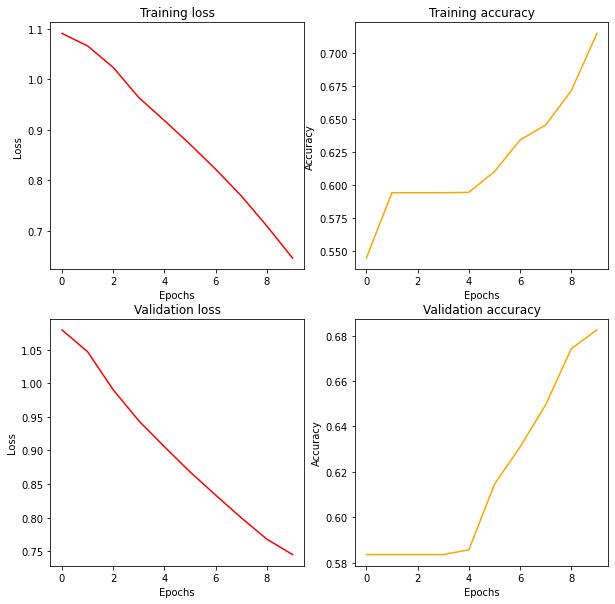

In [18]:
# Đọc các kết quả huấn luyện mô hình qua từng epoch
train_loss, train_acc = history.history['loss'], history.history['accuracy'] # Đọc thông tin loss, acc trên tập train
val_loss, val_acc = history.history['val_loss'], history.history['val_accuracy'] # Đọc thông tin loss, acc trên tập val

plt.figure(figsize=(10, 10)) # Cài đặt kích thước khung ảnh

plt.subplot(2, 2, 1) # Khởi tạo khung ảnh cho training loss
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Loss') # Hiển thị tên trục tung là 'Loss'
plt.title('Training loss') # Hiển thị title của khung ảnh hiện tại là 'Training Loss'
plt.plot(train_loss, color='red') # Vẽ đường giá trị loss trên tập train qua từng epoch (đường vẽ màu đỏ)

plt.subplot(2, 2, 2) # Khởi tạo khung ảnh cho training acc
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Accuracy') # Hiển thị tên trục tung là 'Accuracy'
plt.title('Training accuracy') # Hiển thị title của khung ảnh hiện tại là 'Training accuracy'
plt.plot(train_acc, color='orange') # Vẽ đường giá trị accuracy trên tập train qua từng epoch (đường vẽ màu cam)

plt.subplot(2, 2, 3) # Khởi tạo khung ảnh cho val loss
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Loss') # Hiển thị tên trục tung là 'Loss'
plt.title('Validation loss') # Hiển thị title của khung ảnh hiện tại là 'Validation loss'
plt.plot(val_loss, color='red') # Vẽ đường giá trị loss trên tập val qua từng epoch (đường vẽ màu đỏ)

plt.subplot(2, 2, 4) # Khởi tạo khung ảnh cho val acc
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Accuracy') # Hiển thị tên trục tung là 'Accuracy'
plt.title('Validation accuracy') # Hiển thị title của khung ảnh hiện tại là 'Validation accuracy'
plt.plot(val_acc, color='orange') # Vẽ đường giá trị accuracy trên tập val qua từng epoch (đường vẽ màu cam)

plt.show() # Hiển thị 4 khung ảnh nhỏ